In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import modules and initial setups

In [95]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [96]:
torch.manual_seed(123456)

In [97]:
# check the device
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print('You are using PyTorch version:', torch.__version__, 'Device:', DEVICE)

You are using PyTorch version: 2.1.0+cu121 Device: cpu


In [98]:
# batch and epoch sizes
BATCH_SIZE = 32
EPOCHS = 20

# Download the CIFAR-10 dataset

In [99]:
# download the dataset + train/test split
train_dataset = datasets.CIFAR10(root = './CIFAR_10',     # where the dataset is located
                                 train = True,            # data for training
                                 download = True,
                                 transform = transforms.ToTensor())   # preprocessing; image -> tensor, [0,255] -> [0,1]
test_dataset = datasets.CIFAR10(root = './CIFAR_10',
                                train = False,
                                transform = transforms.ToTensor())

# dataloader (mini-batch unit settings)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [100]:
# check the data set, sizes and types
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size(), 'type:', X_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


- Batch size: 32
- Channel size: 3 (RGB)
- Height: 32
- Width: 32

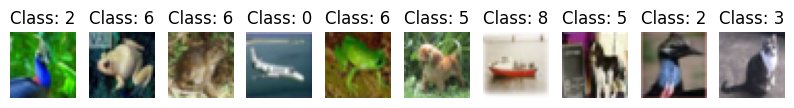

In [101]:
# check the data set, images
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i], (1,2,0)))   # pytorch: (channel, height, width) -> imshow: (height, width, channel)
  plt.title('Class: ' + str(y_train[i].item()));

# CNN modeling

In [102]:
# CNN modeling
class cifarCNN(nn.Module):
  def __init__(self):
    super(cifarCNN, self).__init__()

    # layer 1: input channel 3 // output channel 8 // kernel size: 3 // padding: 1
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels= 8, kernel_size= 3, padding= 1)

    # layer 2: input channel 8 // output channel 16 // kernel size: 3 // padding: 1
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels= 16, kernel_size= 3, padding= 1)

    # max pooling
    self.pool = nn.MaxPool2d(kernel_size= 2, stride= 2)

    # fully connected layer 1: 1024 -> 64
    self.fc1 = nn.Linear(8 * 8 * 16, 64)

    # fully connected layer 2: 64 -> 32
    self.fc2 = nn.Linear(64, 32)

    # fully connected layre 3: 32 -> 10
    self.fc3 = nn.Linear(32, 10)


  def forward(self, x):
    x = self.conv1(x)
    # x dimensions: [32, 8, 32, 32]
    x = F.relu(x)
    x = self.pool(x)    # MaxPool2D (kernel size = 2x2, stride = 2)
    # x dimensions: [32, 8, 16, 16]

    x = self.conv2(x)
    # x dimensions: [32, 16, 16, 16]
    x = F.relu(x)
    x = self.pool(x)
    # x dimensions: [32, 16, 8, 8]

    x = x.view(-1, 16 * 8* 8)   # flatten the tensor to 1 dimension [32, 1024]
    x = self.fc1(x)
    # x dimensions: [32, 64]
    x = F.relu(x)

    x = self.fc2(x)
    # x dimensions: [32, 32]
    x = F.relu(x)

    x = self.fc3(x)
    # x dimensions: [32, 10]
    x = F.log_softmax(x, dim=1)

    return x

In [103]:
# optimizer and loss function
model = cifarCNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

cifarCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [104]:
# training function
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)

    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
          epoch, batch_idx * len(image),
          len(train_loader.dataset), 100 * batch_idx / len(train_loader),
          loss.item()))

  return loss.item()

In [105]:
# evaluation function
import sys

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)

      output = model(image)

      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      # print("prediction size:", prediction.size())
      # print("label size:", label.size())
      # print("prediction:", prediction)
      # print("label:", label)
      # sys.exit()
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100 * correct / len(test_loader.dataset)

  return test_loss, test_accuracy

In [106]:
# train & test CNN
train_losses = []
test_losses = []

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader, optimizer, log_interval = 200)
  train_losses.append(train_loss)

  test_loss, test_accuracy = evaluate(model, test_loader)
  test_losses.append(test_loss)

  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
      epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.285418
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.976869
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.754344
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.880006
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.402603
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.509210
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.502111
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.506619

[EPOCH: 1], 	Test Loss: 1.4489, 	Test Accuracy: 46.66 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.315396
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.818237
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.316067
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.368119
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.190815
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.503226
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.134396
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.682949

[EPOCH: 2], 	Test Loss: 1.2857, 	Test Accuracy: 53.18 % 

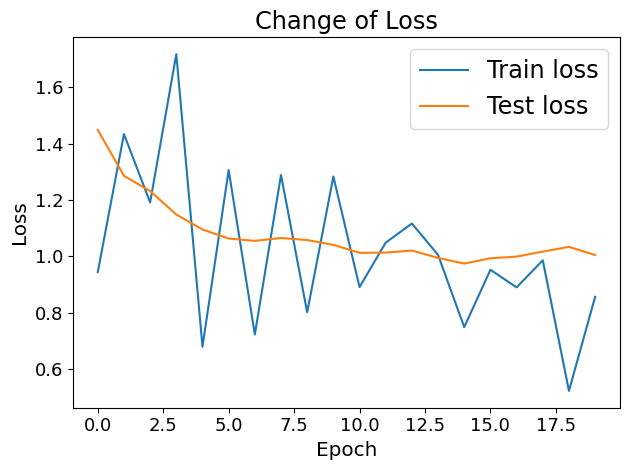

In [107]:
# plotting
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_losses, label='Train loss')
ax.plot(test_losses, label='Test loss')

plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Epoch", fontsize='x-large')
plt.ylabel("Loss", fontsize='x-large')
plt.title("Change of Loss", fontsize='xx-large')

plt.tight_layout()
plt.show();